1.  *Using data from the SQL database since 2010, sort into deciles based on marketcap and compute equally weighted portfolio returns.  What were the mean returns of the decile portfolios?*

In [4]:
import pandas as pd 
from sqlalchemy import create_engine

server = 'fs.rice.edu'
database = 'stocks'
username = 'stocks'
password = '6LAZH1'
driver = 'SQL+Server'
string = f"mssql+pyodbc://{username}:{password}@{server}/{database}" 
try: 
    conn = create_engine(string + "?driver='SQL+Server'").connect()
except:
    try:
        conn = create_engine(string + "?driver='ODBC+Driver+18+for+SQL+Server'").connect()
    except:
        import pymssql
        string = f"mssql+pymssql://{username}:{password}@{server}/{database}"   
        conn = create_engine(string).connect() 

In [5]:
sep_weekly = pd.read_sql(
    """ 
    select date, ticker, closeadj, closeunadj, lastupdated from sep_weekly 
    where date >= '2010-01-01'
    order by ticker, date, lastupdated    
    """,
    conn,
)
sep_weekly = sep_weekly.groupby(["ticker", "date"]).last()
sep_weekly = sep_weekly.drop(columns=["lastupdated"])

ret = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change()
ret.name = "ret"

price = sep_weekly.closeunadj
price.name = "price"

In [6]:
weekly = pd.read_sql(
    """ 
    select date, ticker, marketcap, lastupdated from weekly 
    where date>='2010-01-01'
    order by ticker, date, lastupdated    
    """,
    conn,
)
weekly = weekly.groupby(["ticker", "date"]).last()
weekly = weekly.drop(columns=["lastupdated"])

marketcap = weekly.marketcap 
marketcap.name = "marketcap"

In [11]:
df = pd.concat((price, ret, marketcap), axis=1)
df["ret"] = df.groupby("ticker", group_keys=False).ret.shift(-1)
df = df[df.price>=5].dropna()
df["decile"] = df.groupby("date", group_keys=False).marketcap.apply(
    lambda x: pd.qcut(x, 10, labels=range(1, 11))
)
rets = df.groupby(
    ["date", "decile"], 
    observed=True,
    group_keys=True
).ret.mean().unstack()
print("Annualized percentage mean returns are")
print((100 * 52 * rets.mean()).round(2))

Annualized percentage mean returns are
decile
1      7.22
2     11.28
3     11.82
4     11.13
5     13.33
6     13.27
7     12.64
8     12.21
9     12.91
10    13.35
dtype: float64


2.  *Using data from the SQL database since 2010, sort into quintiles based on momentum and into quintiles based on marketcap and compute equally weighted portfolio returns for the 25 groups.  What were the mean returns?*

In [12]:
ret_annual = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change(52)
ret_monthly = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change(4)
mom = (1 + ret_annual) / (1 + ret_monthly) - 1
mom.name = "mom"

In [16]:
df = pd.concat((price, ret, marketcap, mom), axis=1)
df["ret"] = df.groupby("ticker", group_keys=False).ret.shift(-1)
df = df[df.price>=5].dropna()

df["mom5"] = df.groupby("date", group_keys=False).mom.apply(
    lambda x: pd.qcut(x, 5, labels=range(1, 6))
)
df["mktcap5"] = df.groupby("date", group_keys=False).marketcap.apply(
    lambda x: pd.qcut(x, 5, labels=range(1, 6))
)

rets = df.groupby(
    ["date", "mom5", "mktcap5"], 
    observed=True,
    group_keys=True
).ret.mean().unstack(level=("mom5", "mktcap5"))
print("Annualized percentage mean returns are")
print((100 * 52 * rets.mean()).round(2).unstack())

Annualized percentage mean returns are
mktcap5      1      2      3      4      5
mom5                                      
1        -1.57   7.90   9.25   6.83   9.50
2         9.85   9.15  12.12  10.62  12.31
3        12.61  13.73  11.21  12.96  13.11
4        12.75   9.78  12.28  12.95  12.81
5        14.97  11.97  17.35  14.50  14.05


3.  *Compute volatility for each stock as the standard deviation of the past 52 weekly returns.  Remember to group by ticker when doing so.  Run a backtest of a random forest with max_depth=3, using target2 and including volatility as a feature with mom, pb, marketcap, roe, and assetgr.  Train every 3 years and use 3 years of data each time you train.  Compute portfolio returns for the 100 best stocks (highest predicted value of the target) and the 100 worst stocks (lowest predicted value of the target) each week.  Plot the cumulative compound returns over time.*

In [24]:
volatility = ret.groupby("ticker", group_keys=False).rolling(52).std()
volatility.index = volatility.index.droplevel(0)
volatility.name = "volatility"

In [26]:
weekly = pd.read_sql(
    """ 
    select date, ticker, pb, lastupdated from weekly 
    where date>='2010-01-01'
    order by ticker, date, lastupdated    
    """,
    conn,
)
weekly = weekly.groupby(["ticker", "date"]).last()
weekly = weekly.drop(columns=["lastupdated"])

pb = weekly.pb 
pb.name = "pb"

In [27]:
sf1 = pd.read_sql(
    """ 
    select datekey as date, ticker, assets, netinc, equity, lastupdated from sf1
    where datekey>='2010-01-01' and dimension='ARY' and assets>0 and equity>0
    order by ticker, datekey, lastupdated    
    """,
    conn,
)
sf1 = sf1.groupby(["ticker", "date"]).last()
sf1 = sf1.drop(columns=["lastupdated"])

# change dates to Fridays
from datetime import timedelta 
sf1 = sf1.reset_index()
sf1.date =sf1.date.map(
    lambda x: x + timedelta(4 - x.weekday())
)
sf1 = sf1.set_index(["ticker", "date"])
sf1 = sf1[~sf1.index.duplicated()]

assets = sf1.assets
assets.name = "assets" 
netinc = sf1.netinc 
netinc.name = "netinc" 
equity = sf1.equity
equity.name = "equity"

equity = equity.groupby("ticker", group_keys=False).shift() 
roe = netinc / equity 
roe.name = "roe"

assetgr = assets.groupby("ticker", group_keys=False).pct_change()
assetgr.name = "assetgr"

In [28]:
df = pd.concat(
    (
        ret, 
        mom, 
        price, 
        pb, 
        marketcap, 
        roe, 
        assetgr,
        volatility
        ), 
        axis=1
    )
df["ret"] = df.groupby("ticker", group_keys=False).ret.shift(-1)
df["roe"] = df.groupby("ticker", group_keys=False).roe.ffill()
df["assetgr"] = df.groupby("ticker", group_keys=False).assetgr.ffill()
df = df[df.price >= 5]
df = df.dropna()

df = df.reset_index()
df.date = df.date.astype(str)
df = df[df.date >= "2012-01-01"]

df["target2"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: 100*x.rank(pct=True)
)

features = [
    "mom",
    "pb",
    "marketcap",
    "roe",
    "assetgr",
    "volatility"
]

In [30]:
from sklearn.ensemble import RandomForestRegressor

train_years = 3 # num years of past data to use for training
train_freq = 3  # num years between training 
target = "target2"
model = RandomForestRegressor(max_depth=3)

years = range(2012+train_years, 2024, train_freq)
df2 = None 
for i, year in enumerate(years):
    print(year)
    start_train = f"{year-train_years}-01-01"
    start_predict = f"{year}-01-01"
    if year == years[-1]:
        stop_predict = "2100-01-01"
    else:
        stop_predict = f"{years[i+1]}-01-01"
    past = df[(df.date >= start_train) & (df.date < start_predict)]
    future = df[(df.date>=start_predict) & (df.date<stop_predict)].copy()
    model.fit(X=past[features], y=past[target])
    future["predict"] = model.predict(X=future[features])
    df2 = pd.concat((df2, future))

2015
2018
2021


In [31]:
num_stocks = 100

grouped = df2.groupby("date", group_keys=False).predict
starting_from_best = grouped.rank(ascending=False, method="first")
best = df2[starting_from_best <= num_stocks]
best_rets = best.groupby("date", group_keys=True).ret.mean()
best_rets.index = pd.to_datetime(best_rets.index)

starting_from_worst = grouped.rank(ascending=True, method="first")
worst = df2[starting_from_worst <= num_stocks]
worst_rets = worst.groupby("date", group_keys=True).ret.mean()
worst_rets.index = pd.to_datetime(worst_rets.index)

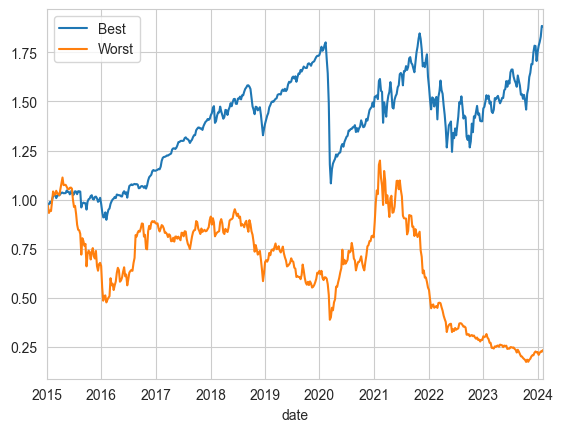

In [32]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style("whitegrid")

(1+best_rets).cumprod().plot(label="Best")
(1+worst_rets).cumprod().plot(label="Worst")
plt.legend()
plt.show()